### Probabilistic Graphical Model - Inpainting Experiment with disentagled CVAE
**Author:** Felipe Cortes Jaramillo

**Description:** We want to do in-painting with the data from the "MLDM-Project", using a disentangled CVAE.

**Idea:** A common approach to encourage disentanglement in VAEs is to modify the Kullback-Leibler (KL) divergence term in the loss function, often by weighing it differently. This approach is seen in β-VAE, where β (beta) is a hyperparameter that balances the latent channel capacity and independence constraints against the reconstruction accuracy.

**References:** The following code was inspired in this paper: https://openreview.net/forum?id=Sy2fzU9gl

### Libraries and Data Pre-processing:

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

import glob
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
# Disable all GPUs
tf.config.set_visible_devices([], 'GPU')

# Check if TensorFlow now only sees CPU
cpus = tf.config.experimental.list_physical_devices('CPU')
if cpus:
    print("Using CPU:", cpus[0])
else:
    raise SystemError("CPU device not found")

# Check if TensorFlow is able to detect the GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Set TensorFlow to use only one GPU
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

#         # Enable memory growth
#         tf.config.experimental.set_memory_growth(gpus[0], True)

#         print("Using GPU:", gpus[0])
#     except RuntimeError as e:
#         # Memory growth must be set at program startup
#         print("RuntimeError:", e)
# else:
#     raise SystemError("GPU device not found")

Using CPU: PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [3]:
# We mount Colab for this
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# Let's load the data (Based on a cut)
images_route_24_30 = f'./../../data/size_480/24_30/'
images_route_22_30 = f'./../../data/size_480/22_30/'
images_route_20_2  = f'./../../data/size_480/20_2/'
#images_route_24_30 = f'./drive/MyDrive/data/size_480/24_30/'
#images_route_22_30 = f'./drive/MyDrive/data/size_480/22_30/'
#images_route_20_2  = f'./drive/MyDrive/data/size_480/20_2/'

filelist_24_30  = sorted(glob.glob(f'{images_route_24_30}*.jpg'))
#filelist_22_30 = sorted(glob.glob(f'{images_route_22_30}*.jpg'))
#filelist_20_2 = sorted(glob.glob(f'{images_route_20_2}*.jpg'))

data_set_24_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_24_30])
#data_set_22_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_22_30])
#data_set_20_2 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_20_2])


# Print shapes
print(f"Shape of data 24_30 set: {data_set_24_30.shape}")
#print(f"Shape of data 22_30 set: {data_set_22_30.shape}")
#print(f"Shape of data 20_2 set: {data_set_20_2.shape}")

Shape of data 24_30 set: (572, 480, 480)


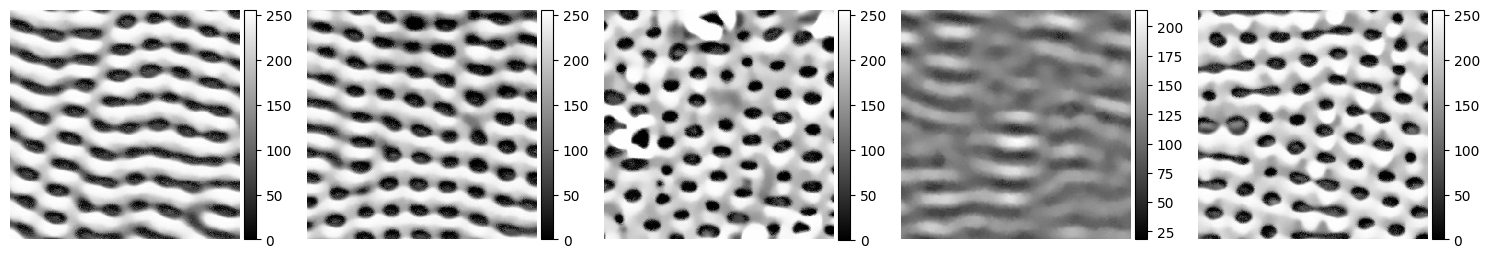

In [5]:
# We can visualize some of the data from the first set (trajectory 24_30)
nb_vis = 5
# Choose nb_vis sample indexes
idx = np.random.choice(data_set_24_30.shape[0], nb_vis, replace=False)
example_digits = [f for f in data_set_24_30[idx, ...]]
# Plot some examples
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [6]:
# Basic normalization step to be in range [0 - 1]

x_24_30 = np.expand_dims(data_set_24_30.astype('float32')/255, -1)
#x_22_30 = np.expand_dims(data_set_22_30.astype('float32')/255, -1)
#x_20_2  = np.expand_dims(data_set_20_2.astype('float32')/255, -1)

In [7]:
# Finally, we define the train, val and test set for each trajectory

X_train_24_30, X_test_24_30 = train_test_split(x_24_30, test_size=0.1, random_state=42)
X_test_24_30, X_eval_24_30 = train_test_split(X_test_24_30, test_size=0.5, random_state=42)

#X_train_22_30, X_test_22_30 = train_test_split(x_22_30, test_size=0.1, random_state=42)
#X_test_22_30, X_eval_22_30 = train_test_split(X_test_22_30, test_size=0.5, random_state=42)

#X_train_20_2, X_test_20_2 = train_test_split(x_20_2, test_size=0.1, random_state=42)
#X_test_20_2, X_eval_20_2 = train_test_split(X_test_20_2, test_size=0.5, random_state=42)

print('< -------- // -------- >')
print(f'Shape of 24_30 training data: {X_train_24_30.shape}, eval data: {X_eval_24_30.shape}, and test data: {X_test_24_30.shape}')
#print(f'Shape of 22_30 training data: {X_train_22_30.shape}, eval data: {X_eval_22_30.shape}, and test data: {X_test_22_30.shape}')
#print(f'Shape of 20_2 training data: {X_train_20_2.shape}, eval data: {X_eval_20_2.shape}, and test data: {X_test_20_2.shape}')

< -------- // -------- >
Shape of 24_30 training data: (514, 480, 480, 1), eval data: (29, 480, 480, 1), and test data: (29, 480, 480, 1)


-----------------------------------------------

In [8]:
def encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs

    # Example convolutional layers
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

    # Shape information for the decoder
    shape = K.int_shape(x)
    print(f"Shape of latent space: {shape}")

    # Generate latent vector Q(z|X)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Encoder model
    encoder = Model(inputs, [z_mean, z_log_var], name='encoder')
    return encoder, shape

In [9]:
def decoder(shape, latent_dim):
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    # Example convolutional transpose layers
    x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = Conv2DTranspose(1, 3, activation='sigmoid', padding='same', name='decoder_output')(x)

    # Decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

In [10]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [11]:
input_shape = (480, 480, 1)  
latent_dim = 48

# Build the encoder and decoder
encoder, shape = encoder(input_shape, latent_dim)
decoder = decoder(shape, latent_dim)

# Define VAE model
inputs = Input(shape=input_shape, name='VAE_input')
z_mean, z_log_var = encoder(inputs)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
reconstruction = decoder(z)

Shape of latent space: (None, 120, 120, 64)


In [12]:
class DisentangledVAELossLayer(tf.keras.layers.Layer):
    def __init__(self, encoder, beta=1.0, **kwargs):
        super(DisentangledVAELossLayer, self).__init__(**kwargs)
        self.encoder = encoder
        self.beta = beta

    def call(self, inputs):
        x, x_decoded = inputs
        z_mean, z_log_var = self.encoder(x)

        reconstruction_loss = binary_crossentropy(K.flatten(x), K.flatten(x_decoded))
        reconstruction_loss *= input_shape[0] * input_shape[1]

        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(K.clip(z_log_var, -100, 100))
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5 * self.beta

        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)

        return x_decoded

# Create Disentangled VAE model
beta_value = 4.0
vae_outputs = DisentangledVAELossLayer(encoder, beta_value)([inputs, reconstruction])
vae = Model(inputs, vae_outputs, name='vae')

# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
vae.compile(optimizer=optimizer)

In [14]:
# We define the callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=7, mode='min', verbose=1)

In [15]:
# Train the model
vae.fit(X_train_24_30, X_train_24_30, epochs=50, batch_size=32, validation_data=(X_eval_24_30, X_eval_24_30))

Epoch 1/50
17/17 [==============================] - 81s 5s/step - loss: 159578.9219 - val_loss: 159385.2188
Epoch 2/50
17/17 [==============================] - 91s 5s/step - loss: 159215.6406 - val_loss: 158939.2812
Epoch 3/50
17/17 [==============================] - 86s 5s/step - loss: 158713.7031 - val_loss: 158253.7656
Epoch 4/50
17/17 [==============================] - 87s 5s/step - loss: 158004.7031 - val_loss: 157277.0625
Epoch 5/50
17/17 [==============================] - 78s 5s/step - loss: 157006.9375 - val_loss: 155937.9844
Epoch 6/50
17/17 [==============================] - 79s 5s/step - loss: 155780.4062 - val_loss: 154274.1719
Epoch 7/50
17/17 [==============================] - 78s 5s/step - loss: 154204.9219 - val_loss: 152835.0156
Epoch 8/50
17/17 [==============================] - 93s 6s/step - loss: 153456.9688 - val_loss: 152119.8750
Epoch 9/50
17/17 [==============================] - 90s 5s/step - loss: 153469.5625 - val_loss: 151660.5156
Epoch 10/50
17/17 [=========

In [16]:
def create_mask(image, mask_size=(150,150), mask_location=(96,96)):
    """Creates a square mask of given size at given location on the image."""
    masked_image = np.copy(image)
    x, y = mask_location
    w, h = mask_size
    masked_image[x:x+w, y:y+h, :] = 0
    return masked_image


def generate_test_images(data, predictions, n_generate=3, mask_size=(150, 150), mask_location=(96, 96)):
    """Generates and plots original, masked, and inpainted images."""
    
    num_images = data.shape[0]

    # Create masked samples and their corresponding masks
    masked_samples = []
    masks = []
    for img in data:
        masked_img = create_mask(img, mask_size, mask_location)
        masked_samples.append(masked_img)

        # Create a mask: 1 where the image is masked, 0 otherwise
        mask = np.zeros_like(img[:, :, 0], dtype=np.float32)
        x, y = mask_location
        w, h = mask_size
        mask[x:x+w, y:y+h] = 1
        masks.append(mask)

    masked_samples = np.array(masked_samples)
    masks = np.array(masks)

    fig, axes = plt.subplots(nrows=n_generate, ncols=3, figsize=(12, 6))

    # Metrics calculations
    ssim_values = []
    psnr_values = []

    for i in range(num_images):
        # Calculate SSIM and PSNR
        inpainted_image = data[i, :, :, 0] * (1 - masks[i]) + predictions[i, :, :, 0] * masks[i]

        # Convert to arrays for SSIM and PSNR calculation
        inpainted_image = data[i, :, :, 0] * (1 - masks[i]) + predictions[i, :, :, 0]* masks[i] 

        current_ssim = ssim(data[i, :, :, 0], inpainted_image, data_range=inpainted_image.max() - inpainted_image.min())
        current_psnr = psnr(data[i, :, :, 0], inpainted_image, data_range=inpainted_image.max() - inpainted_image.min())

        ssim_values.append(current_ssim)
        psnr_values.append(current_psnr)

        if i < n_generate:
            # Original image
            axes[i, 0].imshow(data[i, :, :, 0], cmap='gray')
            axes[i, 0].set_title("Original")
            axes[i, 0].axis('off')

            # Masked image
            axes[i, 1].imshow(masked_samples[i, :, :, 0], cmap='gray')
            axes[i, 1].set_title("Masked")
            axes[i, 1].axis('off')

            # Inpainted image
            inpainted_image = data[i, :, :, 0] * (1 - masks[i]) + predictions[i, :, :, 0] * masks[i]
            axes[i, 2].imshow(inpainted_image, cmap='gray')
            axes[i, 2].set_title("Inpainted")
            axes[i, 2].axis('off')

    # Print average SSIM and PSNR for the batch
    print(f"Average SSIM: {np.mean(ssim_values)}, Average PSNR: {np.mean(psnr_values)}")

    plt.tight_layout()
    plt.show()

Average SSIM: 0.9375016898608343, Average PSNR: 20.952803160271262


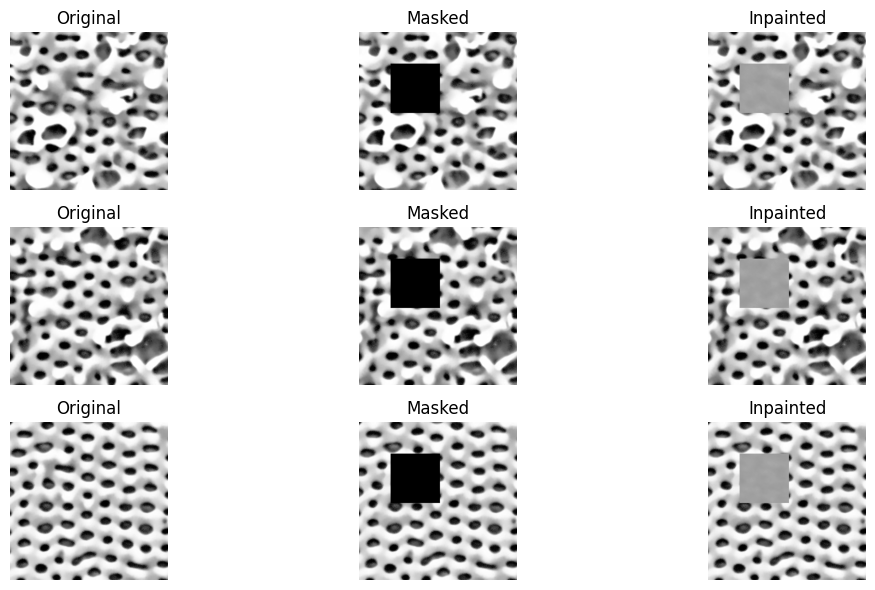

In [17]:
# We get the predictions for the test set
predicted_images = vae.predict(X_test_24_30, verbose=0)
generate_test_images(X_test_24_30, predicted_images, n_generate=3)